### CNN 
(https://shonit2096.medium.com/cnn-on-cifar10-data-set-using-pytorch-34be87e09844)

other CNN: https://medium.com/swlh/image-classification-with-cnn-4f2a501faadb

Libraries

In [20]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

from torch.utils.data import Dataset
from torchvision.transforms import ToTensor

Custom dataset 
(https://pytorch.org/tutorials/beginner/basics/data_tutorial.html)
(https://pytorch.org/tutorials/beginner/data_loading_tutorial.html)

In [21]:
import os
import pandas as pd
from torchvision.io import read_image

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

Rescale images

In [22]:
from skimage import io, transform

class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, image):
        image = image.permute(1, 2, 0)
        img = transform.resize(image, (self.output_size, self.output_size))

        return img


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image = sample

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C x H x W
        image = image.transpose((2, 0, 1))
        return torch.from_numpy(image).float()

Stele dataset with transformations

In [23]:
transformed_dataset = CustomImageDataset(annotations_file='D:\\UniMSc\\MA\\data\\STELES\\lbls.csv',
                                         img_dir='D:\\UniMSc\\MA\\data\\STELES\\imgs\\',
                                         transform=transforms.Compose([
#                                                transforms.Grayscale(num_output_channels=1),
                                               Rescale(28),
                                               ToTensor(),
#                                                transforms.Normalize((0.5), (0.5))
                                           ]))

Visualise transformed stele dataset sample

0 torch.Size([1, 28, 28]) 0
1 torch.Size([1, 28, 28]) 0
2 torch.Size([1, 28, 28]) 0
3 torch.Size([1, 28, 28]) 0


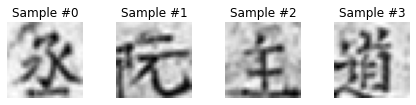

In [24]:
fig = plt.figure()

for i in range(len(transformed_dataset)):
    image, label = transformed_dataset[i]

    print(i, image.shape, label)

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    plt.imshow(image.permute(1, 2, 0), cmap='gray')

    if i == 3:
        plt.show()
        break

CUDA

In [25]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is not available.  Training on CPU ...


Data Preparation

In [26]:
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20
# percentage of training set to use as validation
valid_size = 0.2# convert data to torch.FloatTensor
test_size = 0.1

num_train = len(transformed_dataset)
indices = list(range(num_train))
np.random.shuffle(indices)
valid_split = int(np.floor(valid_size * num_train))
test_split = int(np.floor(test_size * num_train))
train_index, valid_index = indices[valid_split:], indices[:valid_split]# define samplers for obtaining training and validation batches
train_index, test_index = indices[test_split:], indices[:test_split]
train_sampler = SubsetRandomSampler(train_index)
valid_sampler = SubsetRandomSampler(valid_index)# prepare data loaders
test_sampler = SubsetRandomSampler(test_index)
train_loader = torch.utils.data.DataLoader(transformed_dataset, batch_size = batch_size, 
                                           sampler = train_sampler, num_workers = num_workers)
valid_loader = torch.utils.data.DataLoader(transformed_dataset, batch_size = batch_size,
                                          sampler = valid_sampler, num_workers = num_workers)
test_loader = torch.utils.data.DataLoader(transformed_dataset, batch_size = batch_size,
                                         sampler = test_sampler, num_workers = num_workers)

# specify the image classes
classes = ['style ' + str(i) for i in range(21)]

In [27]:
# print(train_data[0])
print(transformed_dataset[0])

(tensor([[[0.8669, 0.8773, 0.8700, 0.8549, 0.8506, 0.8032, 0.7442, 0.6873,
          0.5763, 0.5487, 0.5794, 0.6343, 0.7125, 0.8060, 0.8314, 0.8314,
          0.8233, 0.8394, 0.8666, 0.8510, 0.8431, 0.8353, 0.8333, 0.8507,
          0.8627, 0.8586, 0.8417, 0.7931],
         [0.8793, 0.8745, 0.8614, 0.8549, 0.8258, 0.6978, 0.5769, 0.5403,
          0.5021, 0.5157, 0.6111, 0.7121, 0.7759, 0.8198, 0.8351, 0.8479,
          0.8179, 0.8162, 0.8533, 0.8400, 0.8392, 0.8431, 0.8510, 0.8627,
          0.8529, 0.8201, 0.8188, 0.8009],
         [0.8804, 0.8586, 0.8321, 0.8231, 0.7609, 0.5903, 0.4877, 0.5296,
          0.5571, 0.5545, 0.6583, 0.7766, 0.8281, 0.8445, 0.8695, 0.8816,
          0.8082, 0.7728, 0.8385, 0.8681, 0.8536, 0.8392, 0.8339, 0.8378,
          0.8338, 0.8132, 0.8061, 0.7931],
         [0.8736, 0.8365, 0.8000, 0.7799, 0.7027, 0.5710, 0.5610, 0.6626,
          0.6709, 0.6294, 0.6833, 0.7896, 0.8463, 0.8519, 0.8333, 0.8220,
          0.7053, 0.6377, 0.7395, 0.8493, 0.8765, 0.8472

Network architecture

In [28]:
import torch.nn as nn
import torch.nn.functional as F

# define CNN architecture
# class Net(nn.Module):  
#     def __init__(self):
#         super(Net, self).__init__()
#         self.conv1 = nn.Conv2d(1, 6, 5)
#         self.pool = nn.MaxPool2d(2, 2)
#         self.conv2 = nn.Conv2d(6, 16, 5)
#         self.fc1 = nn.Linear(16 * 4*4, 120)
#         self.fc2 = nn.Linear(120, 84)
#         self.fc3 = nn.Linear(84, 21)  
        
#     def forward(self, x):
#         x = self.pool(F.relu(self.conv1(x)))
#         x = self.pool(F.relu(self.conv2(x)))
#         x = x.view(-1, 16 * 4*4)
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = self.fc3(x)
#         return x
class Net(nn.Module):  
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv4 = nn.Conv2d(128, 128, 5)
        self.conv5 = nn.Conv2d(128, 256, 3, padding=1)
        self.conv6 = nn.Conv2d(256, 256, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 4*4, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 21)  
        self.droput = nn.Dropout(0.2)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))  # output: 64 x 12 x 12
        x = F.relu(self.conv3(x))
        x = self.pool(F.relu(self.conv4(x)))  # output: 128 x 4 x 4
#         x = F.relu(self.conv5(x))
#         x = self.pool(F.relu(self.conv6(x)))
        x = x.view(-1, 128 * 4*4)  # flatten
        x = F.relu(self.fc1(x))
        x = self.droput(x)
        x = F.relu(self.fc2(x))
        x = self.droput(x)
        x = self.fc3(x)
        return x

# create a complete CNN
model = Net()
print(model)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1))
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(256, 256, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2048, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=21, bias=True)
  (droput): Dropout(p=0.2, inplace=False)
)


Loss function and optimiser

In [29]:
# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()# specify optimizer (stochastic gradient descent) and learning rate = 0.01
optimizer = torch.optim.SGD(model.parameters(),lr = 0.01)

Training

Epoch: 1 	Training Loss: 2.735608 	Validation Loss: 0.606338
Validation loss decreased (inf --> 0.606338).  Saving model ...
Epoch: 2 	Training Loss: 2.726434 	Validation Loss: 0.604519
Validation loss decreased (0.606338 --> 0.604519).  Saving model ...
Epoch: 3 	Training Loss: 2.717897 	Validation Loss: 0.602341
Validation loss decreased (0.604519 --> 0.602341).  Saving model ...
Epoch: 4 	Training Loss: 2.710253 	Validation Loss: 0.600831
Validation loss decreased (0.602341 --> 0.600831).  Saving model ...
Epoch: 5 	Training Loss: 2.706715 	Validation Loss: 0.600004
Validation loss decreased (0.600831 --> 0.600004).  Saving model ...
Epoch: 6 	Training Loss: 2.698348 	Validation Loss: 0.595619
Validation loss decreased (0.600004 --> 0.595619).  Saving model ...
Epoch: 7 	Training Loss: 2.644617 	Validation Loss: 0.572835
Validation loss decreased (0.595619 --> 0.572835).  Saving model ...
Epoch: 8 	Training Loss: 2.559689 	Validation Loss: 0.538695
Validation loss decreased (0.57283

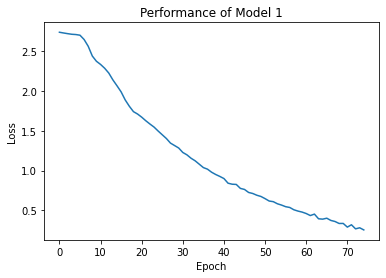

In [30]:
# number of epochs to train the model
n_epochs = 75 #List to store loss to visualize
train_losslist = []
valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)   
    
    train_losslist.append(train_loss)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = valid_loss

plt.plot([*range(n_epochs)], train_losslist)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Performance of Model 1")
plt.show()

Load best model

In [31]:
model.load_state_dict(torch.load('model_cifar.pt'))

<All keys matched successfully>

Test network

In [32]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(21))
class_total = list(0. for i in range(21))

model.eval()
# iterate over test data
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(len(target)):
        label = target.data[i]
        class_correct[label] += correct[i].item() if len(target) > 1 else correct.item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(21):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.061648

Test Accuracy of style 0: 76% (36/47)
Test Accuracy of style 1: 71% (27/38)
Test Accuracy of style 2: 81% (27/33)
Test Accuracy of style 3: 67% (29/43)
Test Accuracy of style 4: 53% (26/49)
Test Accuracy of style 5: 79% (31/39)
Test Accuracy of style 6: 80% (36/45)
Test Accuracy of style 7: 74% (40/54)
Test Accuracy of style 8: 79% (27/34)
Test Accuracy of style 9: 96% (32/33)
Test Accuracy of style 10: 83% (25/30)
Test Accuracy of style 11: 57% (12/21)
Test Accuracy of style 12: 85% (17/20)
Test Accuracy of style 13: 85% (18/21)
Test Accuracy of style 14: 66% (16/24)
Test Accuracy of style 15: 91% (34/37)
Test Accuracy of style 16: 97% (42/43)
Test Accuracy of style 17: 68% (11/16)
Test Accuracy of style 18: 86% (32/37)
Test Accuracy of style 19: 100% (68/68)
Test Accuracy of style 20: 94% (34/36)

Test Accuracy (Overall): 80% (620/768)


Visualise test results

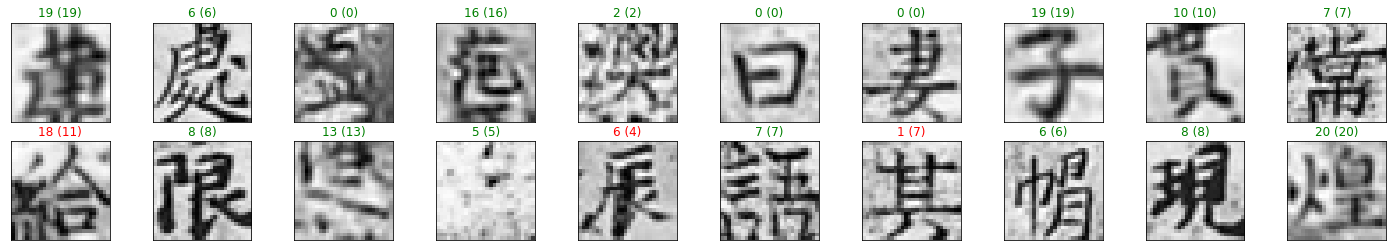

In [33]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()# get sample outputs
# if cuda:
#     model.to(device)
#     images, labels = images.to(device), labels.to(device)
output = model(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)
# prep images for display
images = images.numpy()# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                 color=("green" if preds[idx]==labels[idx] else "red"))